<a href="https://colab.research.google.com/github/rklepov/hse-cs-ml-2018-2019/blob/homework/10-CV/HW/hw2/AugmentationHW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dogs vs. Cats. Augmentation.

В этом домашнем задании вам предлагается сравнить несколько стратегий аугментации. Задача достачно простая и чтобы сравнение имело смысл, мы не будем брать готовые архитектуры, а будем обучать свою с нуля.

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [0]:
import os
import cv2

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.callbacks as callbacks

from tensorflow.keras.models import Sequential

In [0]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

[Kaggle API](https://github.com/Kaggle/kaggle-api)

In [0]:
!pip install -q kaggle --upgrade

In [0]:
from google.colab import files

if not os.path.exists('kaggle.json'):
    files.upload()

In [6]:
%%bash

test -e dogs-vs-cats-redux-kernels-edition || {
    chmod 600 kaggle.json
    KAGGLE_CONFIG_DIR='./' kaggle competitions download -c dogs-vs-cats-redux-kernels-edition
    unzip -oq '*.zip' -d dogs-vs-cats-redux-kernels-edition
}

100%|##########| 271M/271M [00:01<00:00, 174MB/s]
100%|##########| 544M/544M [00:03<00:00, 185MB/s]
100%|##########| 111k/111k [00:00<00:00, 117MB/s]

2 archives were successfully processed.


## Функции загрузки данных

In [0]:
import re
from random import shuffle
from glob import glob

BATCH_SIZE = 32

train_files = glob(os.path.sep.join(['dogs-vs-cats-redux-kernels-edition','train','*.jpg']))
test_files = glob(os.path.sep.join(['dogs-vs-cats-redux-kernels-edition','test','*.jpg']))

In [0]:
def load_image_array(path, target_size=None):
    return img_to_array(load_img(path, target_size=target_size))

# загружаем входное изображение и предобрабатываем
def load_image_preproc(path, target_size=IMG_SIZE):
    array = load_image_array(path, target_size=target_size) # загрузка и масштабирование изображения
    return preprocess_input(array) # предобработка для VGG16

def classify_path(path):
    # dog=1, cat=0
    return 1. if re.match(f'.*{os.path.sep}dog\\.\\d', path) else 0.    

Ваша задача реализовать 5 функций для аугментации и сравнить между собой качество моделей, которые обучались с различными аугментациями.

In [0]:
def identity(**kwargs):
    return kwargs['x'], kwargs['y']

def flip(**kwargs):
    # отзеркаливание вдоль оси x картинки
    return cv2.flip(kwargs['x'], 0), kwargs['y']

def rotation(**kwargs):
    # вращение картинки, но при этом не очень большое

    # https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python

    img = kwargs['x']
    max_deg = kwargs['max_angle_degree'] if 'max_angle_degree' in kwargs else 15

    h, w = img.shape[:2]
    cX, cY = (w // 2, h // 2)
    theta = np.random.choice([-1, 1]) * (1 + np.random.randint(max_deg))
    M = cv2.getRotationMatrix2D((cX, cY), theta, 1.0)
    img_rotated = cv2.warpAffine(img, M, (w, h))

    return img_rotated, kwargs['y']

def make_crop_rect(img, min_portion=0.1, max_portion=0.6):
    h, w = img.shape[:2]
    xlen = np.random.randint(np.int(w * min_portion), np.int(w * max_portion))
    xoffs = np.random.randint(0, w - xlen)
    ylen = np.random.randint(np.int(h * min_portion), np.int(h * max_portion))
    yoffs = np.random.randint(0, h - ylen)
    return xoffs, yoffs, xoffs + xlen, yoffs + ylen

def calc_rect_square(*args):
    # площадь прямоугольника
    # (без проверки корректности аргументов)
    if 2 == len(args): # длина - ширина
        return np.prod(args)
    elif 4 == len(args): # координаты в ожидаемом порядке
        x1, y1, x2, y2 = args 
        return (x2 - x1) * (y2 - y1)
    return 0

def cutout(**kwargs):
    # вырезание случайного прямоугольника
    # будем вырезать случайный кусок, но не более 50% по ширине или высоте
    img = kwargs['x']

    x1, y1, x2, y2 = make_crop_rect(img)
    img_cutout = img.copy() # на всякий случай не меняем исходное ихображение
    img_cutout[x1:x2, y1:y2, :] = img.dtype.type(0)
    
    return img_cutout, kwargs['y']   

def mixup(**kwargs):
    # смешивание двух картинок со случайным весом alpha.
    # target при этом тоже должен смешиваться. То есть если вы смешали собаку и кота с весами 0.75 и 0.25.
    # То кросс-энтропия должна считаться для таргетов 0.75 и 0.25

    img = kwargs['x']
    y = kwargs['y']
    other_path = kwargs['other_path']
    y_other = kwargs['y_other']
    image_loader = kwargs['image_loader']

    alpha = kwargs['alpha'] if 'alpha' in kwargs else 0.25

    # https://github.com/yu4u/mixup-generator
    # https://medium.com/swlh/how-to-do-mixup-training-from-image-files-in-keras-fe1e1c1e6da6
    lmbda = np.random.beta(alpha, alpha)
    img_mixup = img.copy()
    other_img = image_loader(other_path, target_size=img.shape[:2]).astype(img.dtype)
    img_mixup = (img_mixup * lmbda + other_img * (1 - lmbda)).astype(img.dtype)

    return img_mixup, y * lmbda + y_other * (1 - lmbda)

def cutmix(**kwargs):
    # вырезание кусочка из одной картинки и вставка в другую картинку.
    # target тоже должны смешиваться
    # не забудьте убедиться, что лосс считается правильно
    # ссылка на статью: http://openaccess.thecvf.com/content_ICCV_2019/papers/Yun_CutMix_Regularization_Strategy_to_Train_Strong_Classifiers_With_Localizable_Features_ICCV_2019_paper.pdf

    img = kwargs['x']
    y = kwargs['y']
    other_path = kwargs['other_path']
    y_other = kwargs['y_other']
    image_loader = kwargs['image_loader']

    # изображения одинакового размера
    other_img = image_loader(other_path, target_size=img.shape[:2]).astype(img.dtype)
    rect = make_crop_rect(img)
    cutout_square = calc_rect_square(*rect)
    total_square = calc_rect_square(*img.shape[:2])

    img_cutmix = img.copy() # на всякий случай не меняем исходное ихображение
    x1, y1, x2, y2 = rect
    img_cutmix[x1:x2, y1:y2, :] = other_img[x1:x2, y1:y2, :]

    return img_cutmix, (y_other * cutout_square / total_square) + (y * (total_square - cutout_square) / total_square)

![augs.png](https://github.com/rklepov/hse-cs-ml-2018-2019/raw/homework/10-CV/HW/hw2/augs.png "augs.png")

In [0]:
AUGMENTATIONS = {
    'none' : identity,
    'flip': flip,
    'rotation': rotation,
    'cutout': cutout,
    'mixup': mixup,
    'cutmix': cutmix
}

## Иллюстрация работы функций аугментации

In [0]:
def plot_simple_aug(aug, img_path, y=None, **kwargs):
    img = load_image_array(img_path).astype(np.uint8)
    _, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    aug_img, y = aug(x=img, y=y, image_loader=load_image_array, **kwargs)
    ax1.imshow(img)
    ax2.imshow(aug_img)
    return y

### Поворот

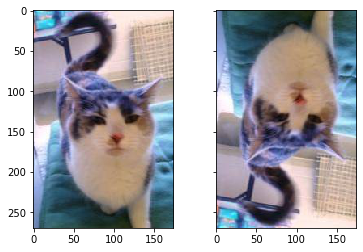

In [12]:
plot_simple_aug(flip, test_files[99])

### Вращение

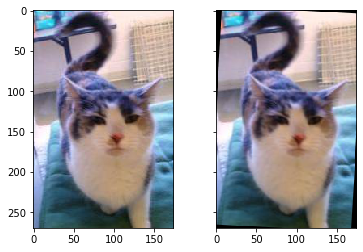

In [13]:
plot_simple_aug(rotation, test_files[99], max_angle_degree=20)

### Вырезание части изображения

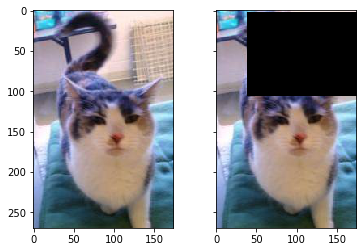

In [14]:
plot_simple_aug(cutout, test_files[99])

### Вставка части другого изображения

0.2236270753512133

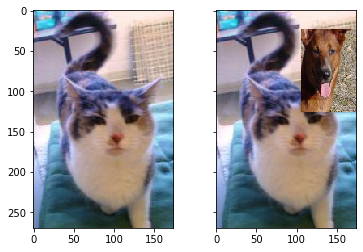

In [15]:
plot_simple_aug(cutmix, test_files[99], y=0., other_path=test_files[988], y_other=1.)

0.9413805309734513

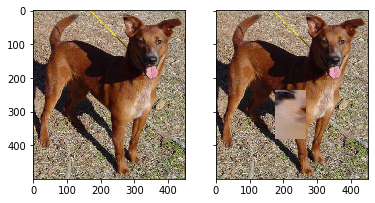

In [16]:
plot_simple_aug(cutmix, test_files[988], y=1., other_path=test_files[99], y_other=0.)

### Подмешивание изображения

0.6650482726866089

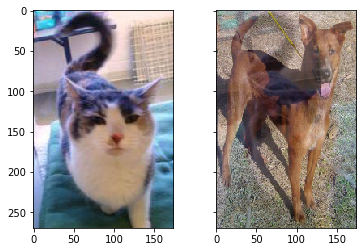

In [17]:
plot_simple_aug(mixup, test_files[99], y=0., other_path=test_files[988], y_other=1., alpha=0.5)

0.4467809077712836

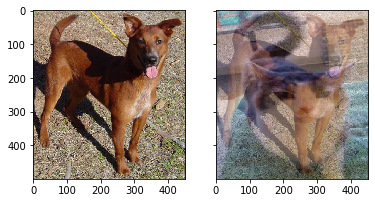

In [18]:
plot_simple_aug(mixup, test_files[988], y=1., other_path=test_files[99], y_other=0., alpha=0.5)

## Генератор обучающей выборки

In [0]:
# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=BATCH_SIZE, augmentation_strategies=['none']):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size + (1 * (0 < len(files) % batch_size))):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j -= j % len(files)
            x = np.array([load_image_preproc(path) for path in files[i:j]])
            y = np.array([classify_path(path) for path in files[i:j]])

            for ix, strategy in enumerate(np.random.choice(augmentation_strategies, j - i)):
                # путь второго файла (для аугментаций, которым он нужен)
                # выбираем произвольный, кроме текущего (возможно, из того же самого батча)
                other_path_ix = np.random.choice(np.r_[0:i + ix, 1 + i + ix:len(files)], 1)[0]
                x[ix], y[ix] = AUGMENTATIONS[strategy](x=x[ix], y=y[ix],
                                                       other_path=files[other_path_ix],
                                                       y_other=classify_path(files[other_path_ix]),
                                                       image_loader=load_image_preproc)
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image_preproc(path)])

## Визуализируем примеры для обучения

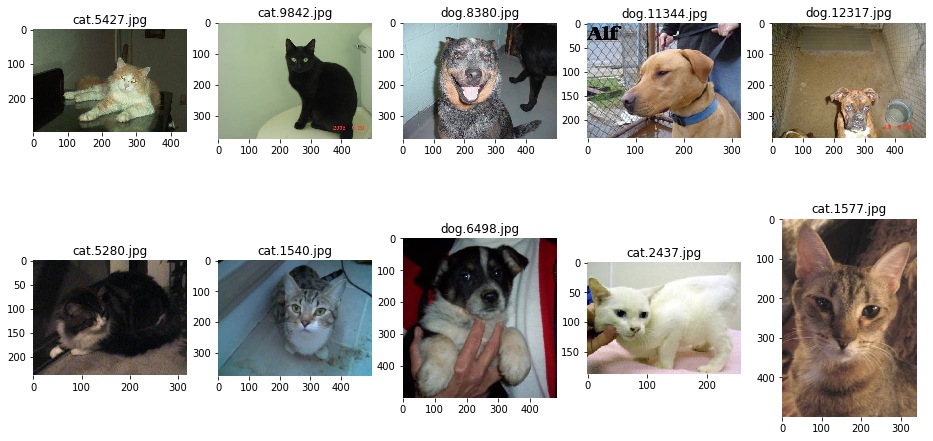

In [20]:
fig = plt.figure(figsize=(16, 8))
for i, path_ix in enumerate(np.random.choice(len(train_files), 10, replace=False), 1):
    path = train_files[path_ix]
    subplot = fig.add_subplot(2, 5, i, frameon=False)
    subplot.imshow(plt.imread(path));
    subplot.set_title(path.split(os.path.sep)[-1]);

## Определяем модель
Напишите сверточную нейронную сеть с 5-6 слоями. В конце вставьте полносвязный слой с одним выходом и оберните его в сигмоиду.

In [0]:
def build_model(input_shape):
    
    model = Sequential()
    
    for filters in np.power(2, np.arange(4, 4 + 2)): # 16, 32
        model.add(L.Conv2D(filters, (3, 3), padding='same', input_shape=input_shape))
        model.add(L.LeakyReLU())
        model.add(L.Conv2D(filters, (3, 3)))
        model.add(L.LeakyReLU())
        model.add(L.MaxPooling2D(pool_size=(2, 2)))
        model.add(L.Dropout(rate=0.25))
        
    model.add(L.Flatten())
    model.add(L.Dense(64))
    model.add(L.LeakyReLU())
    model.add(L.Dropout(rate=0.5))
    model.add(L.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss)
              metrics=['accuracy'])
    
    return model

In [22]:
build_model(IMG_SIZE + (3, )).summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 224, 224, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 16)      2320      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 222, 222, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
dropout (Drop

## Компилируем модель и запускаем обучение

In [0]:
shuffle(train_files)  # перемешиваем обучающую выборку
train_val_split = 1000  # число изображений в валидационной выборке

In [0]:
def train_model(model, save_path,
                train_files, validation_files,
                augmentation_strategies,
                epochs=100):

    validation_data = next(fit_generator(validation_files, batch_size=len(validation_files)))

    # запускаем процесс обучения
    model.fit_generator(
        fit_generator( # данные читаем функцией-генератором
            train_files[train_val_split:],
            batch_size=BATCH_SIZE,
            augmentation_strategies = augmentation_strategies),
        steps_per_epoch= len(train_files[train_val_split:]) // BATCH_SIZE,  # число вызовов генератора за эпоху
        epochs=epochs,  # число эпох обучения
        validation_data=validation_data,
        callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=11),
                   callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1),
                   callbacks.ModelCheckpoint(monitor='val_loss', filepath=save_path, save_best_only=True, verbose=1)]
    )

    return model

def load_model_or_train(model_name, augmentation_strategies,
                        train_files=train_files, train_val_split=train_val_split):
    if not os.path.exists(f'{model_name}.hdf5'):
        validation_files = train_files[:train_val_split]
        np.save(f'{model_name}-validation_files.npy', np.array(validation_files))
        model = build_model(IMG_SIZE + (3, ))
        train_model(model, f'{model_name}.hdf5',
                    train_files[train_val_split:], validation_files,
                    augmentation_strategies=augmentation_strategies)
    else:
        model = tf.keras.models.load_model(f'{model_name}.hdf5')
        validation_files = np.load(f'{model_name}-validation_files.npy')

    return model, validation_files

def predict(model, validation_files):
    y_true = [ classify_path(path) for path in validation_files ]
    y_proba = model.predict_generator(predict_generator(validation_files),
                                      len(validation_files)).squeeze()
    return y_true, y_proba

# Задание

Обучите 3 модели.
1. Выключить аугментацию
2. Включить flip, rotation, crop
3. Включить всё

Сравните ROC-AUC на тестовой выборке.

При реализации mixup и cutmix немного перепишете чтение данных с диска. Для каждого примера в батче нужно находить случайную пару из датасета.

## Функции для построения ROC-AUC и PR-AUC кривых

In [0]:
import sklearn
from sklearn.metrics import (roc_curve, precision_recall_curve, classification_report)

def plot_curve_xy(x, y):    
    plt.plot(x, y, lw=3)

def plot_curve(nrc, curve, y_test, y_probs, title, xlabel, ylabel):
    plt.subplot(nrc)
    auc = curve(y_test, y_probs)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f'{title} AUC={auc:.3f}')
    plt.grid()

def plot_roc_curve(y_test, y_probs):
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    plot_curve_xy(fpr, tpr)
    return sklearn.metrics.auc(fpr, tpr)

def plot_pr_curve(y_test, y_probs):
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    plot_curve_xy(recall, precision)
    return sklearn.metrics.auc(recall, precision)

## Модель без аугментации

In [26]:
model_no_aug, validation_files = load_model_or_train('cats-dogs-noaug', ['none'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### ROC-AUC
 Для валидационной выборки.

In [0]:
y_true, y_proba = predict(model_no_aug, validation_files)

In [28]:
print(classification_report(y_true, (y_proba > 0.5).astype(np.float)))

              precision    recall  f1-score   support

         0.0       0.73      0.82      0.77       518
         1.0       0.77      0.67      0.72       482

    accuracy                           0.75      1000
   macro avg       0.75      0.74      0.74      1000
weighted avg       0.75      0.75      0.75      1000



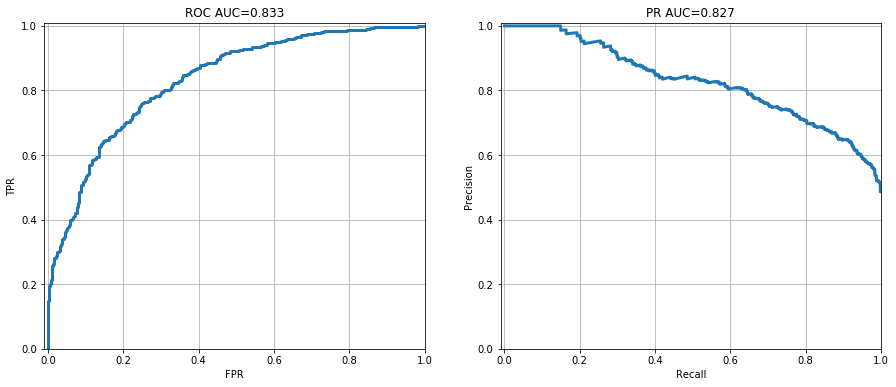

In [29]:
plt.figure(figsize=(15, 6))

plot_curve(121, plot_roc_curve, y_true, y_proba, 'ROC', 'FPR', 'TPR')
plot_curve(122, plot_pr_curve, y_true, y_proba, 'PR', 'Recall', 'Precision')

plt.show();

## Модель с простыми аугментациями

In [0]:
model_basic_aug, validation_files = load_model_or_train('cats-dogs-basicaug',
                                                        ['none', 'flip', 'rotation', 'cutout'])

### ROC-AUC
 Для валидационной выборки.

In [0]:
y_true, y_proba = predict(model_basic_aug, validation_files)

In [32]:
print(classification_report(y_true, (y_proba > 0.5).astype(np.float)))

              precision    recall  f1-score   support

         0.0       0.84      0.83      0.84       518
         1.0       0.82      0.84      0.83       482

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



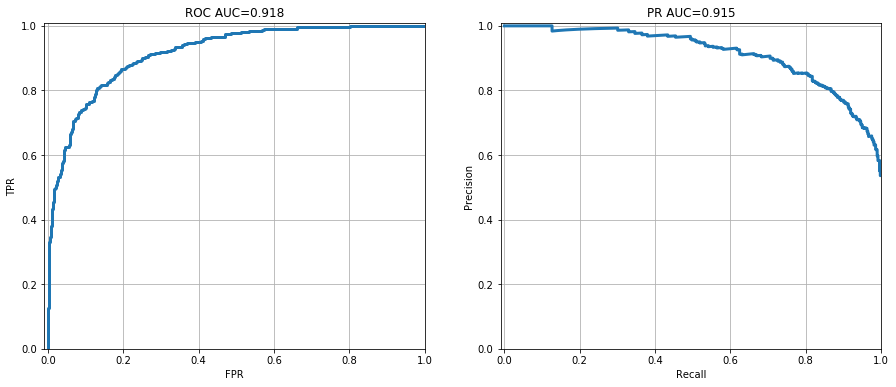

In [33]:
plt.figure(figsize=(15, 6))

plot_curve(121, plot_roc_curve, y_true, y_proba, 'ROC', 'FPR', 'TPR')
plot_curve(122, plot_pr_curve, y_true, y_proba, 'PR', 'Recall', 'Precision')

plt.show();

## Модель со всеми аугментациями

In [0]:
model_all_aug, validation_files = load_model_or_train('cats-dogs-allaug',
                                                      ['none', 'flip', 'rotation', 'cutout', 'mixup', 'cutmix'])

### ROC-AUC
 Для валидационной выборки.

In [0]:
y_true, y_proba = predict(model_all_aug, validation_files)

In [36]:
print(classification_report(y_true, (y_proba > 0.5).astype(np.float)))

              precision    recall  f1-score   support

         0.0       0.83      0.86      0.84       518
         1.0       0.84      0.81      0.82       482

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



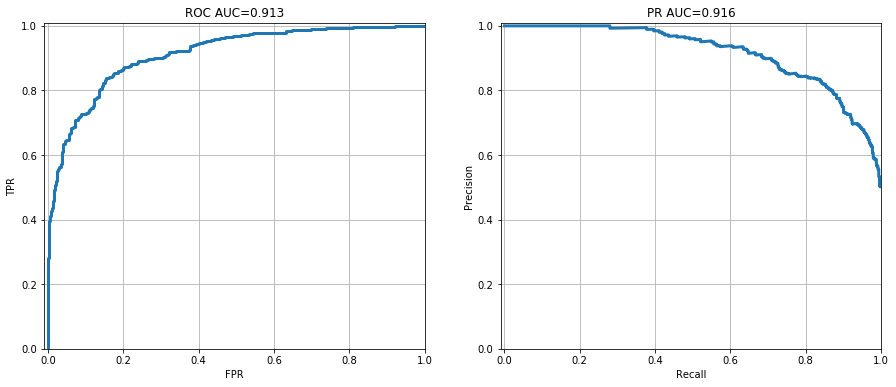

In [37]:
plt.figure(figsize=(15, 6))

plot_curve(121, plot_roc_curve, y_true, y_proba, 'ROC', 'FPR', 'TPR')
plot_curve(122, plot_pr_curve, y_true, y_proba, 'PR', 'Recall', 'Precision')

plt.show();

## Предсказания на проверочной выборке

Поскольку это [соревнование kaggle](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition "Dogs vs. Cats Redux: Kernels Edition | Kaggle"), то для тестовых данных разметки нет. Поэтому просто визуально оценим качество предсказаний на небольшом числе фотографий.

In [0]:
pred = model_all_aug.predict_generator(predict_generator(test_files[80:][:10]), steps=10, max_queue_size=10)

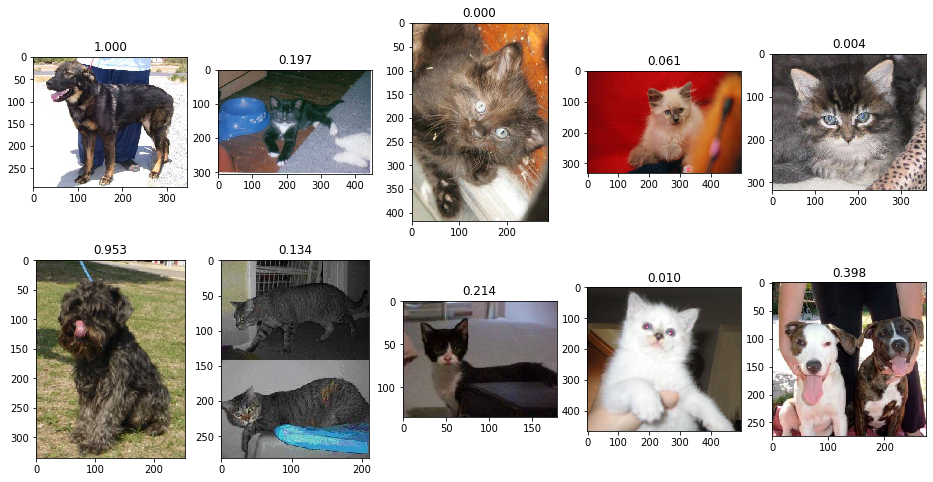

In [39]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred), 1):
    subplot = fig.add_subplot(2, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title(f'{score[0]:.3f}');

### Submission на Kaggle

Для интереса попробуем отправить submission на уже завершённое соревнование.

Формат файла на отправку:

In [40]:
!head -5 sample_submission.csv

id,label
1,0.5
2,0.5
3,0.5
4,0.5


Прогнозы на тестовой выборке (без разметки):

In [0]:
y_pred = ( model_all_aug
          .predict_generator(predict_generator(test_files),
                             steps=len(test_files),
                             max_queue_size=500)
          .squeeze() )

Извлекаем идентификатор из имени файла:

In [42]:
test_files[:3]

['dogs-vs-cats-redux-kernels-edition/test/11467.jpg',
 'dogs-vs-cats-redux-kernels-edition/test/5379.jpg',
 'dogs-vs-cats-redux-kernels-edition/test/1110.jpg']

In [0]:
ids = [ int(file.split('/')[2].split('.')[0]) for file in test_files ]

Сохранение в формате `.csv`:

In [0]:
import pandas as pd

subm = pd.DataFrame(zip(ids, y_pred), columns=['id', 'label'])

subm.sort_values(by=['id']).to_csv('submission.csv', index=False, float_format='%.15f')

In [45]:
!head -5 submission.csv

id,label
1,0.885868251323700
2,0.998392164707184
3,0.143120363354683
4,0.999888181686401


Score (log loss): `0.42594`. Было бы место #908 из 1315.